# Classical classifiers

This notebook shows how well classical classifiers solve the sentence classification problem. This is mainly needed to have a baseline for quantum solution to compare against.

We first load our library files and the required packages.

In [22]:
import sys
import os
import json
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

sys.path.append("../../models/classical/")

from NNClassifier import (loadData,evaluate, NNClassifier,
       prepareTrainTestXYWords, prepareTrainTestXYSentence,)

We have implemented sentence vectorization using pretrained BERT cased and uncased (see [Git](https://github.com/google-research/bert), [arXiv](https://arxiv.org/abs/1810.04805)) base models (each sentence is represented as a 768-dimensional real-valued vector), sentence transformer models *all-mpnet-base-v2* and *all-distilroberta-v1* (see [link](https://www.sbert.net/docs/pretrained_models.html)) as well as word-level vectorization using [_fastText_](https://fasttext.cc/) model pretrained on [English Wikipedia and Common Crawl](hhttps://fasttext.cc/docs/en/crawl-vectors.html) (each word in a sentence is represented as a 300-dimensional real-valued vector).

The Jupyter notebook *Prepare_datasets_4classifier.ipynb* shows how to filterdata and acquire embedding vectors using different vectorization models.

In [2]:
datadir = "../../data/datasets"
dsName='amazonreview_train'

In [3]:
modeldir="../../models/classical"

## 1. Training shallow feedforward neural network

To train shallow feedforward neural network models we employ sentence level embeddings. 

In [4]:
embName='BERT_CASED'

In [5]:
data = loadData(f"{datadir}/{dsName}_{embName}.json")
print(f"Training samples: {len(data['train_data'])}, test samples: {len(data['test_data'])}")
print(f"An example sentence: {data['train_data'][2]['sentence']}, class: {data['train_data'][2]['class']}, syntactical tag: {data['train_data'][2]['tag']}")
print(f"Vectorized sentence dimension: {len(data['train_data'][0]['sentence_vectorized'][0])}")

Training samples: 183918, test samples: 20436
An example sentence: A fascinatiing story, class: 2, syntactical tag: n[(n/n)   n[(n/n)   n]]
Vectorized sentence dimension: 768


We reformat the data as numpy arrays for classifier training. 

In [6]:
trainX, trainY, testX, testY = prepareTrainTestXYSentence(data,classify_by_field="class")
print(f"{trainX.shape}")
print(f"{trainY.shape}")
print(f"{testX.shape}")
print(f"{testY.shape}")

(183918, 768)
(183918, 2)
(20436, 768)
(20436, 2)


Now we train a feedforward neural network classifier.

In [7]:
classifier = NNClassifier()
history = classifier.train(trainX, trainY)

Epoch 1/100
5748/5748 - 4s - loss: 0.4699 - accuracy: 0.7719 - 4s/epoch - 618us/step
Epoch 2/100
5748/5748 - 3s - loss: 0.4565 - accuracy: 0.7790 - 3s/epoch - 583us/step
Epoch 3/100
5748/5748 - 3s - loss: 0.4536 - accuracy: 0.7799 - 3s/epoch - 587us/step
Epoch 4/100
5748/5748 - 3s - loss: 0.4527 - accuracy: 0.7799 - 3s/epoch - 581us/step
Epoch 5/100
5748/5748 - 3s - loss: 0.4522 - accuracy: 0.7797 - 3s/epoch - 573us/step
Epoch 6/100
5748/5748 - 3s - loss: 0.4517 - accuracy: 0.7810 - 3s/epoch - 577us/step
Epoch 7/100
5748/5748 - 3s - loss: 0.4513 - accuracy: 0.7810 - 3s/epoch - 579us/step
Epoch 8/100
5748/5748 - 3s - loss: 0.4514 - accuracy: 0.7802 - 3s/epoch - 575us/step
Epoch 9/100
5748/5748 - 3s - loss: 0.4511 - accuracy: 0.7809 - 3s/epoch - 567us/step
Epoch 10/100
5748/5748 - 3s - loss: 0.4510 - accuracy: 0.7811 - 3s/epoch - 563us/step
Epoch 11/100
5748/5748 - 3s - loss: 0.4511 - accuracy: 0.7813 - 3s/epoch - 565us/step
Epoch 12/100
5748/5748 - 3s - loss: 0.4504 - accuracy: 0.7818 -

Epoch 97/100
5748/5748 - 3s - loss: 0.4501 - accuracy: 0.7816 - 3s/epoch - 583us/step
Epoch 98/100
5748/5748 - 3s - loss: 0.4504 - accuracy: 0.7812 - 3s/epoch - 581us/step
Epoch 99/100
5748/5748 - 4s - loss: 0.4501 - accuracy: 0.7821 - 4s/epoch - 643us/step
Epoch 100/100
5748/5748 - 4s - loss: 0.4504 - accuracy: 0.7824 - 4s/epoch - 640us/step


## 2. Evaluating shallow feedforward neural network

The *history* object returned by *train* function holds a record of the metric values during training.

In [8]:
nn_train_acc = history.history["accuracy"][-1]
print(f"FNN train accuracy on {embName} vectors: {nn_train_acc}")

FNN train accuracy on BERT_CASED vectors: 0.7823812961578369


And measure the accuracy on the test set.

In [9]:
res = classifier.predict(testX)
nn_test_acc = evaluate(res, testY)
print(f"FFNN test accuracy on {embName} vectors: {nn_test_acc}")

639/639 [==============================] - 0s 469us/step
FFNN test accuracy on BERT_CASED vectors: 0.7851830103738501


For comparison we employ the nierest neighbor algorithm on the same data. We calculate the accuracy of classifying the sentence with the label corresponding to the closest sentence in the training data.

In [10]:
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(trainX, trainY)
res = neigh.predict(testX)
neigh_test_acc = np.sum(res == testY)/2/len(testY)
neigh_train_acc = neigh.score(trainX, trainY)
print(f"Nearest neighbor test accuracy: {neigh_test_acc}, train accuracy: {neigh_train_acc}")

Nearest neighbor test accuracy: 0.7376688197298884, train accuracy: 1.0


Depending on random, the FNN classifier might perform better or worse (or the same) than the 1-nearest neighbor algorithm.

## 3. Training convolutional neural network classifier

Now we load fastText word embeddings and train a convolutional network on them.

In [11]:
data = loadData(f"{datadir}/{dsName}_FASTTEXT.json")

maxLen = 6
trainX, trainY, testX, testY = prepareTrainTestXYWords(data, maxLen,classify_by_field="class")

cnnclassifier = NNClassifier(model="CNN", vectorSpaceSize=300)
history = cnnclassifier.train(trainX, trainY)

Epoch 1/30
5748/5748 - 13s - loss: 0.3943 - accuracy: 0.8194 - 13s/epoch - 2ms/step
Epoch 2/30
5748/5748 - 13s - loss: 0.3648 - accuracy: 0.8336 - 13s/epoch - 2ms/step
Epoch 3/30
5748/5748 - 13s - loss: 0.3518 - accuracy: 0.8401 - 13s/epoch - 2ms/step
Epoch 4/30
5748/5748 - 14s - loss: 0.3431 - accuracy: 0.8450 - 14s/epoch - 2ms/step
Epoch 5/30
5748/5748 - 14s - loss: 0.3341 - accuracy: 0.8503 - 14s/epoch - 2ms/step
Epoch 6/30
5748/5748 - 14s - loss: 0.3262 - accuracy: 0.8538 - 14s/epoch - 2ms/step
Epoch 7/30
5748/5748 - 14s - loss: 0.3187 - accuracy: 0.8586 - 14s/epoch - 2ms/step
Epoch 8/30
5748/5748 - 14s - loss: 0.3132 - accuracy: 0.8614 - 14s/epoch - 2ms/step
Epoch 9/30
5748/5748 - 14s - loss: 0.3058 - accuracy: 0.8662 - 14s/epoch - 2ms/step
Epoch 10/30
5748/5748 - 14s - loss: 0.2996 - accuracy: 0.8688 - 14s/epoch - 2ms/step
Epoch 11/30
5748/5748 - 14s - loss: 0.2948 - accuracy: 0.8718 - 14s/epoch - 2ms/step
Epoch 12/30
5748/5748 - 14s - loss: 0.2900 - accuracy: 0.8746 - 14s/epoch 

## 4. Evaluating convolutional neural network classifier

In [12]:
fasttext_nn_train_acc = history.history['accuracy'][-1]
print(f"CNN train accuracy on fastText vectors: {fasttext_nn_train_acc}")

CNN train accuracy on fastText vectors: 0.9067084193229675


In [13]:
res = cnnclassifier.predict(testX)
fasttext_nn_test_acc = evaluate(res, testY)
print(f"CNN test accuracy on fastText vectors: {fasttext_nn_test_acc}")

639/639 [==============================] - 1s 1ms/step
CNN test accuracy on fastText vectors: 0.8319632021922099


## 5. Comparing results

Now we will show results (train and test accuracies) in a chart.

In [14]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,6)
test_accs = [fasttext_nn_test_acc, neigh_test_acc, nn_test_acc]
train_accs = [fasttext_nn_train_acc, neigh_train_acc, nn_train_acc]
labels = ["fastText CNN",f"{embName} nearest neighbors", f"{embName} NN"]

To compare results we will train models for other sentence embeddings as well.

In [15]:
for currEmb in ['BERT_UNCASED', 'all-distilroberta', 'all-mpnet-base']:
    data = loadData(f"{datadir}/{dsName}_{currEmb}.json")
    trainX, trainY, testX, testY = prepareTrainTestXYSentence(data,classify_by_field="class")

    currclassifier = NNClassifier()
    history = currclassifier.train(trainX, trainY)

    labels.append(f"{currEmb} NN")
    curr_train_acc = history.history["accuracy"][-1]
    train_accs.append(curr_train_acc)
    
    res = currclassifier.predict(testX)
    curr_test_acc = evaluate(res, testY)
    test_accs.append(curr_test_acc)

Epoch 1/100
5748/5748 - 3s - loss: 0.4250 - accuracy: 0.8053 - 3s/epoch - 592us/step
Epoch 2/100
5748/5748 - 3s - loss: 0.4116 - accuracy: 0.8104 - 3s/epoch - 559us/step
Epoch 3/100
5748/5748 - 3s - loss: 0.4098 - accuracy: 0.8107 - 3s/epoch - 557us/step
Epoch 4/100
5748/5748 - 3s - loss: 0.4088 - accuracy: 0.8109 - 3s/epoch - 564us/step
Epoch 5/100
5748/5748 - 3s - loss: 0.4086 - accuracy: 0.8114 - 3s/epoch - 558us/step
Epoch 6/100
5748/5748 - 3s - loss: 0.4082 - accuracy: 0.8113 - 3s/epoch - 559us/step
Epoch 7/100
5748/5748 - 3s - loss: 0.4076 - accuracy: 0.8121 - 3s/epoch - 559us/step
Epoch 8/100
5748/5748 - 3s - loss: 0.4075 - accuracy: 0.8120 - 3s/epoch - 559us/step
Epoch 9/100
5748/5748 - 3s - loss: 0.4076 - accuracy: 0.8117 - 3s/epoch - 561us/step
Epoch 10/100
5748/5748 - 3s - loss: 0.4074 - accuracy: 0.8115 - 3s/epoch - 561us/step
Epoch 11/100
5748/5748 - 3s - loss: 0.4075 - accuracy: 0.8125 - 3s/epoch - 562us/step
Epoch 12/100
5748/5748 - 3s - loss: 0.4072 - accuracy: 0.8120 -

Epoch 97/100
5748/5748 - 3s - loss: 0.4069 - accuracy: 0.8121 - 3s/epoch - 571us/step
Epoch 98/100
5748/5748 - 3s - loss: 0.4066 - accuracy: 0.8120 - 3s/epoch - 581us/step
Epoch 99/100
5748/5748 - 3s - loss: 0.4070 - accuracy: 0.8122 - 3s/epoch - 576us/step
Epoch 100/100
5748/5748 - 3s - loss: 0.4073 - accuracy: 0.8116 - 3s/epoch - 567us/step
639/639 [==============================] - 0s 466us/step
Epoch 1/100
5748/5748 - 3s - loss: 0.4059 - accuracy: 0.8130 - 3s/epoch - 607us/step
Epoch 2/100
5748/5748 - 3s - loss: 0.3817 - accuracy: 0.8220 - 3s/epoch - 573us/step
Epoch 3/100
5748/5748 - 3s - loss: 0.3793 - accuracy: 0.8228 - 3s/epoch - 573us/step
Epoch 4/100
5748/5748 - 3s - loss: 0.3781 - accuracy: 0.8232 - 3s/epoch - 570us/step
Epoch 5/100
5748/5748 - 3s - loss: 0.3773 - accuracy: 0.8242 - 3s/epoch - 565us/step
Epoch 6/100
5748/5748 - 3s - loss: 0.3766 - accuracy: 0.8244 - 3s/epoch - 571us/step
Epoch 7/100
5748/5748 - 3s - loss: 0.3762 - accuracy: 0.8245 - 3s/epoch - 571us/step
Epo

Epoch 92/100
5748/5748 - 3s - loss: 0.3727 - accuracy: 0.8257 - 3s/epoch - 567us/step
Epoch 93/100
5748/5748 - 3s - loss: 0.3727 - accuracy: 0.8259 - 3s/epoch - 566us/step
Epoch 94/100
5748/5748 - 3s - loss: 0.3727 - accuracy: 0.8261 - 3s/epoch - 581us/step
Epoch 95/100
5748/5748 - 3s - loss: 0.3727 - accuracy: 0.8257 - 3s/epoch - 572us/step
Epoch 96/100
5748/5748 - 3s - loss: 0.3727 - accuracy: 0.8260 - 3s/epoch - 564us/step
Epoch 97/100
5748/5748 - 3s - loss: 0.3727 - accuracy: 0.8263 - 3s/epoch - 560us/step
Epoch 98/100
5748/5748 - 3s - loss: 0.3726 - accuracy: 0.8258 - 3s/epoch - 566us/step
Epoch 99/100
5748/5748 - 3s - loss: 0.3727 - accuracy: 0.8260 - 3s/epoch - 565us/step
Epoch 100/100
5748/5748 - 3s - loss: 0.3727 - accuracy: 0.8259 - 3s/epoch - 572us/step
639/639 [==============================] - 0s 461us/step
Epoch 1/100
5748/5748 - 4s - loss: 0.3807 - accuracy: 0.8286 - 4s/epoch - 624us/step
Epoch 2/100
5748/5748 - 3s - loss: 0.3565 - accuracy: 0.8367 - 3s/epoch - 588us/ste

Epoch 87/100
5748/5748 - 4s - loss: 0.3476 - accuracy: 0.8401 - 4s/epoch - 624us/step
Epoch 88/100
5748/5748 - 4s - loss: 0.3476 - accuracy: 0.8396 - 4s/epoch - 625us/step
Epoch 89/100
5748/5748 - 4s - loss: 0.3476 - accuracy: 0.8403 - 4s/epoch - 622us/step
Epoch 90/100
5748/5748 - 4s - loss: 0.3476 - accuracy: 0.8401 - 4s/epoch - 615us/step
Epoch 91/100
5748/5748 - 4s - loss: 0.3476 - accuracy: 0.8403 - 4s/epoch - 609us/step
Epoch 92/100
5748/5748 - 3s - loss: 0.3477 - accuracy: 0.8399 - 3s/epoch - 606us/step
Epoch 93/100
5748/5748 - 3s - loss: 0.3476 - accuracy: 0.8399 - 3s/epoch - 606us/step
Epoch 94/100
5748/5748 - 4s - loss: 0.3476 - accuracy: 0.8400 - 4s/epoch - 609us/step
Epoch 95/100
5748/5748 - 4s - loss: 0.3476 - accuracy: 0.8402 - 4s/epoch - 635us/step
Epoch 96/100
5748/5748 - 4s - loss: 0.3476 - accuracy: 0.8397 - 4s/epoch - 651us/step
Epoch 97/100
5748/5748 - 4s - loss: 0.3476 - accuracy: 0.8401 - 4s/epoch - 614us/step
Epoch 98/100
5748/5748 - 3s - loss: 0.3477 - accuracy:

All results are presented in the bar chart.

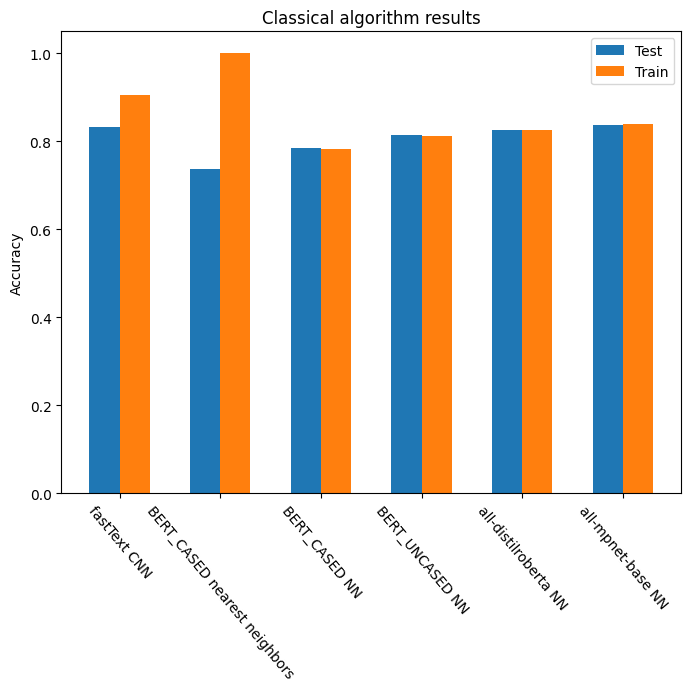

In [16]:
width = 0.3
plt.bar(np.arange(len(test_accs)) - (width/2), test_accs, width=width)
plt.bar(np.arange(len(train_accs)) + (width/2), train_accs, width=width)
plt.xticks(range(len(labels)), labels, rotation=-50)
plt.ylabel("Accuracy")
plt.title("Classical algorithm results")
plt.legend(["Test", "Train"])
plt.show()

All results are saved to file.

In [17]:
with open(f"{modeldir}/{dsName}_results.json", "w", encoding="utf-8") as f:
        json.dump({"train_accuracy": train_accs, "test_accuracy": test_accs, "model type": labels}, f, indent=1, ensure_ascii=False)

## 6. Saving, loading and re-using models

!!! To save the model use function save. The function's argument is the folder name where trained model's files will be saved.

In [23]:
classifier.save(f"{modeldir}/{dsName}_{embName}")

INFO:tensorflow:Assets written to: ../../models/classical/amazonreview_train_BERT_CASED\assets


INFO:tensorflow:Assets written to: ../../models/classical/amazonreview_train_BERT_CASED\assets


!!! To load previousely saved model create *NNClassifier* object and use function *load*. The function's argument is the folder name where trained model's files are saved. In this example *newclassifier* object after loading will become replica of *classifier* object.

In [28]:
newclassifier = NNClassifier()
newclassifier.load(f"{modeldir}/{dsName}_{embName}")

Failed to load model from ../../models/classical/amazonreview_train_BERT_CASED


False

!!! To use newclassifier for prediction use function *predict* and pass embedding vector of the sentence.